In [1]:
from train_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses

c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Moien'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = 200)
mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = 90)
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [5]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11]
if USER == MOIEN:
    train_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\train\\','D:\python\SoilNet\dataset\LUCAS_2015_all.csv',l8_bands=bands, transform=train_transform)
elif USER == NAFISEH:
    train_ds = SNDataset('C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\l8_images\\train',\
                        'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\LUCAS_2015_all.csv',l8_bands=bands, transform=train_transform) #Nafiseh 
if USER == MOIEN:
    test_ds = SNDataset('D:\python\SoilNet\dataset\l8_images\\test\\','D:\python\SoilNet\dataset\LUCAS_2015_all.csv',l8_bands=bands, transform=test_transform)
elif USER == NAFISEH:
    test_ds = SNDataset('C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\l8_images\\test',\
                        'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-1\\dataset\\LUCAS_2015_all.csv',l8_bands=bands, transform=test_transform) #Nafiseh 

In [6]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 100 if USER == NAFISEH else 5
LR_SCHEDULER = "step" # step, plateau or None
USE_SPATIAL_ATTENTION = False

In [7]:
train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [8]:
from soilnet.soil_net import SoilNetFC, ResNet

In [9]:
#model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
if USE_SPATIAL_ATTENTION:
    model = ResNet(resnet_architecture="101+GLAM",cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
else:
    model = ResNet(resnet_architecture="101",cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)

In [10]:
# # Get image and label from custom DataLoader
# img_custom, label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [11]:
cv_results = {"train_loss": [],
               "test_loss": [],
               "MAE": [],
               "R2": []
    }

In [12]:
SEEDS = [1, 7, 14] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [13]:
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    results = train(model, train_dl, test_dl, torch.optim.Adam(model.parameters(), lr=LEARNING_RATE), RMSELoss(), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER)
    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['test_loss'].append(results['test_loss'])
    cv_results['MAE'].append(results['MAE'][0])
    cv_results['R2'].append(results['R2'][0])

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 13/13 [00:07<00:00,  1.69it/s, Train_Loss=0.114]


 Epoch 1 Results: |  train_loss: 0.11421098560094833 |  test_loss: 0.09947032108902931  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 13/13 [00:04<00:00,  2.63it/s, Train_Loss=0.109]


 Epoch 2 Results: |  train_loss: 0.10863119764969899 |  test_loss: 0.09945139804711708  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.59it/s, Train_Loss=0.108]


 Epoch 3 Results: |  train_loss: 0.10758675835453547 |  test_loss: 0.09945837007119106  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 13/13 [00:04<00:00,  2.63it/s, Train_Loss=0.109]


 Epoch 4 Results: |  train_loss: 0.10902594574368916 |  test_loss: 0.09925782651855396  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.58it/s, Train_Loss=0.112]


 Epoch 5 Results: |  train_loss: 0.11207131239084098 |  test_loss: 0.09842479802094974  

Adjusting learning rate of group 0 to 1.0000e-04.


c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\moi3n\miniconda3\envs\pytorchGPU\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 CROSS VAL 2 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.55it/s, Train_Loss=0.108]


 Epoch 1 Results: |  train_loss: 0.10774481239227149 |  test_loss: 0.09856593723480518  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.59it/s, Train_Loss=0.109]


 Epoch 2 Results: |  train_loss: 0.10886032449511382 |  test_loss: 0.10168150841043545  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 13/13 [00:04<00:00,  2.65it/s, Train_Loss=0.109]


 Epoch 3 Results: |  train_loss: 0.10910411551594734 |  test_loss: 0.10341206594155385  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 13/13 [00:04<00:00,  2.62it/s, Train_Loss=0.104]


 Epoch 4 Results: |  train_loss: 0.1035223465699416 |  test_loss: 0.09929693518922879  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 13/13 [00:04<00:00,  2.67it/s, Train_Loss=0.106]


 Epoch 5 Results: |  train_loss: 0.1060611095566016 |  test_loss: 0.09826574589197452  

Adjusting learning rate of group 0 to 1.0000e-04.
 CROSS VAL 3 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 13/13 [00:04<00:00,  2.66it/s, Train_Loss=0.109]


 Epoch 1 Results: |  train_loss: 0.10851759377580422 |  test_loss: 0.09928179303040871  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.44it/s, Train_Loss=0.103]


 Epoch 2 Results: |  train_loss: 0.10263042381176582 |  test_loss: 0.09852638840675354  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.49it/s, Train_Loss=0.105]


 Epoch 3 Results: |  train_loss: 0.10529943885138401 |  test_loss: 0.09789218753576279  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.49it/s, Train_Loss=0.103]


 Epoch 4 Results: |  train_loss: 0.1034360771568922 |  test_loss: 0.09751208642354378  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 13/13 [00:05<00:00,  2.55it/s, Train_Loss=0.107] 


 Epoch 5 Results: |  train_loss: 0.10689095522348697 |  test_loss: 0.09869183915165755  

Adjusting learning rate of group 0 to 1.0000e-04.


somehow the test_loss is smaller than train_loss -> could be due to small smaple dataset

In [15]:
train_arr = np.asarray(cv_results['train_loss'])
test_arr = np.asarray(cv_results['test_loss'])
train_arr.shape, test_arr.shape

((3, 5), (3, 5))

In [29]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
dt_string = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Formatted date and time:", dt_string)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Formatted date and time: D_2023_05_03_T_20_07


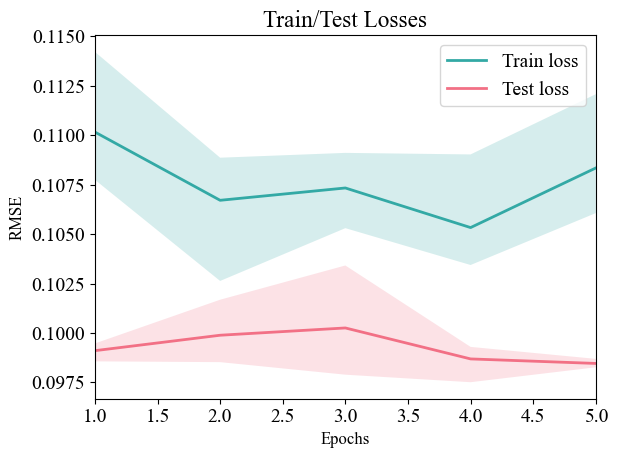

In [31]:
plot_train_test_losses(train_arr,test_arr, title="Train/Test Losses", x_label="Epochs", y_label="RMSE", min_max_bounds= True, tight_x_lim= True, save_path=f"results/run_{dt_string}_{USER}.png")